In [81]:
library(tidyverse)
library(caret)
library(AppliedPredictiveModeling)
library(Rtsne)
library(dplyr)
.libPaths("/root/R/x86_64-conda_cos6-linux-gnu-library/3.5")
library(cluster)
library(fpc)
library(gridExtra,quietly = T)


Attaching package: ‘gridExtra’

The following object is masked from ‘package:randomForest’:

    combine

The following object is masked from ‘package:dplyr’:

    combine



# Loading ESS-MCCS Data

In [3]:
mccs_ess <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ess_mccs_data.csv",stringsAsFactors=FALSE)

dim(mccs_ess)

ess_siv_probs <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ESS_SIV_Probes.csv")

dim(ess_siv_probs)

[1] 6926 3836

[1] 2210   31

In [4]:
table(mccs_ess$CancerCellType)


    BC    CRC Kidney   Lung   MBCN     PC    UCC 
   866   1668    282    662    870   1726    852 

In [5]:
#select ProbIDs
probeIDs <-ess_siv_probs[c("CG","UCSC.browser.coordinates")]

select_columns <- c('CancerCellType','AlcoholAmount', 'CaseControl','Smoking','bcell','bmi_rrto','cd4t','cd8t','gran','mono','nk')


cancer_cases <- mccs_ess[mccs_ess$CaseControl!=1,]

myvars <- names(cancer_cases) %in% c('Sample','ID','AlcoholAmount','CaseControl','Smoking','bcell','bmi_rrto','cd4t','cd8t','gran','mono','nk')
cancer_cases_methy <- cancer_cases[!myvars]

cancer_cases_methy_ESS_SIV <- cancer_cases_methy[,ess_siv_probs$CG]

cancer_cases_methy_ESS_SIV_cg <- cancer_cases_methy_ESS_SIV[ , !(names(cancer_cases_methy_ESS_SIV) %in% c("CancerCellType"))]

nums <- unlist(lapply(cancer_cases_methy_ESS_SIV_cg, is.numeric))
cancer_cases_methy_ESS_SIV_cg <- cancer_cases_methy_ESS_SIV_cg[,nums]



cancer_cases_methy_ESS_SIV_cg <- cancer_cases_methy_ESS_SIV_cg[ , colSums(is.na(cancer_cases_methy_ESS_SIV_cg)) == 0]
head(cancer_cases_methy_ESS_SIV)
dim(mccs_ess)


,cg03492136,cg25769590,cg23649088,cg25602718,cg07234508,cg24719726,cg03074188,cg00819233,cg05912338,cg07234876,⋯,cg19721055,cg20607798,cg20618651,cg21232488,cg03188948,cg18902978,cg19151808,cg25817165,cg25325723,cg21918786
1,3.411191,0.3822916,2.17572728,4.213013,1.1090564,3.428756,-1.958672,4.060164,0.7374268,5.3389623,⋯,5.130235,-1.169833,0.9873620,-0.2876672,-0.3630766,-4.068136,-0.34036082,0.9256159,4.852117,4.745145
4,3.903715,2.1439821,2.10445078,1.369702,7.9566586,3.315308,-1.279448,4.434092,2.9847213,0.8554057,⋯,8.580103,-1.965128,2.2590226,-1.0290855,-3.6314047,-3.877797,0.14849324,-0.1073317,1.392656,2.654273
5,4.069919,0.3436572,0.72483941,2.247164,0.2213000,2.674918,-1.477084,4.786576,1.1973321,3.8492824,⋯,5.548779,-3.528800,2.9440624,-1.3220859,-2.5553984,-4.388768,0.08583344,-0.5663364,3.326830,3.052435
8,4.371070,1.9953190,-1.03704535,1.067601,2.4695555,4.728938,-1.012473,4.856164,2.4445835,0.6763981,⋯,7.720827,-2.130468,-0.1501937,-0.7773924,-1.8589368,-3.852477,0.68247797,0.0605548,4.013712,3.625365
9,5.249979,0.6347563,-0.28127731,1.805233,-0.3626122,2.029848,-1.399338,1.024801,1.0270510,4.1247939,⋯,1.043619,-2.434710,1.1102838,-1.8842120,5.0117542,-4.243884,-0.59335249,-0.2965560,NA,5.022191
11,3.798693,2.4427495,0.03293707,2.014408,3.9910787,3.729533,-1.967829,5.168323,2.8096620,4.1399186,⋯,5.211337,-1.826182,2.6370324,-0.1554798,-1.4507748,-3.717704,0.28622605,1.2222834,3.058508,4.683261


[1] 6926 3836

In [6]:
set.seed(9)
tsne_model_1 = Rtsne(as.matrix(cancer_cases_methy_ESS_SIV_cg), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)

[1] 3463    3

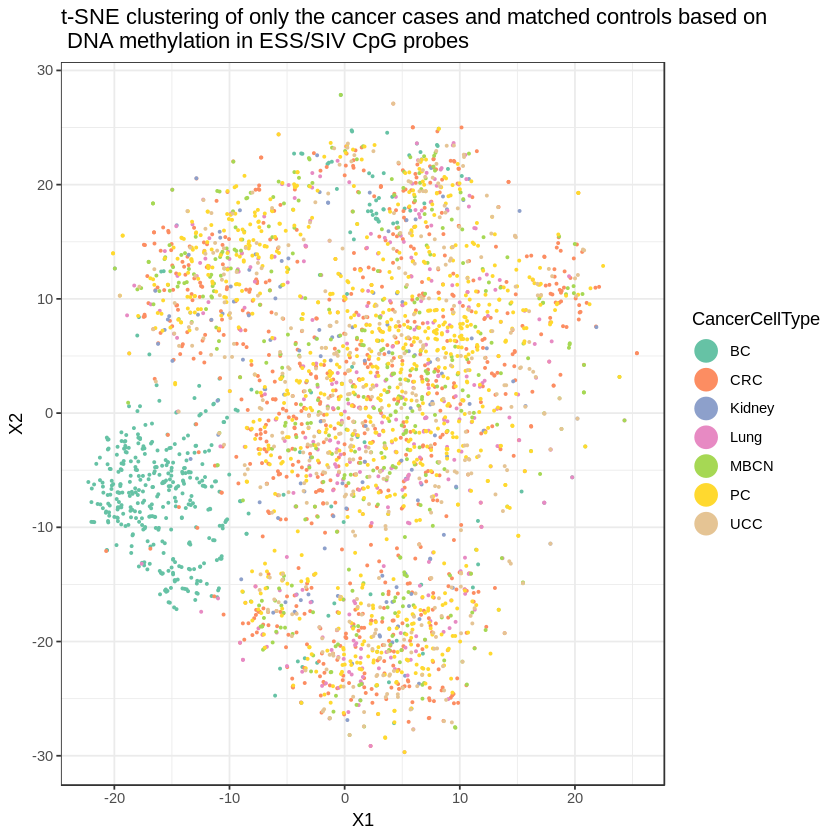

In [7]:
d_tsne_1 = as.data.frame(tsne_model_1$Y)

d_tsne_1$CancerCellType <- cancer_cases_methy_ESS_SIV$CancerCellType

#d_tsne_1$CancerCellType <- d_tsne_1$CancerCellType=="BC"
dim(d_tsne_1)

## plotting the results without clustering
ggplot(d_tsne_1, aes(x=V1, y=V2,colour = CancerCellType)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("X1") + ylab("X2") +theme_bw()+
  ggtitle("t-SNE clustering of only the cancer cases and matched controls based on \n DNA methylation in ESS/SIV CpG probes") +
  scale_colour_brewer(palette = "Set2")
ggsave("cancer_case_control.png", width = 10, height = 8)

## tSNE plots considering cancer cases 

[1]  433 1626
[1] 433   3
[1]  834 1703


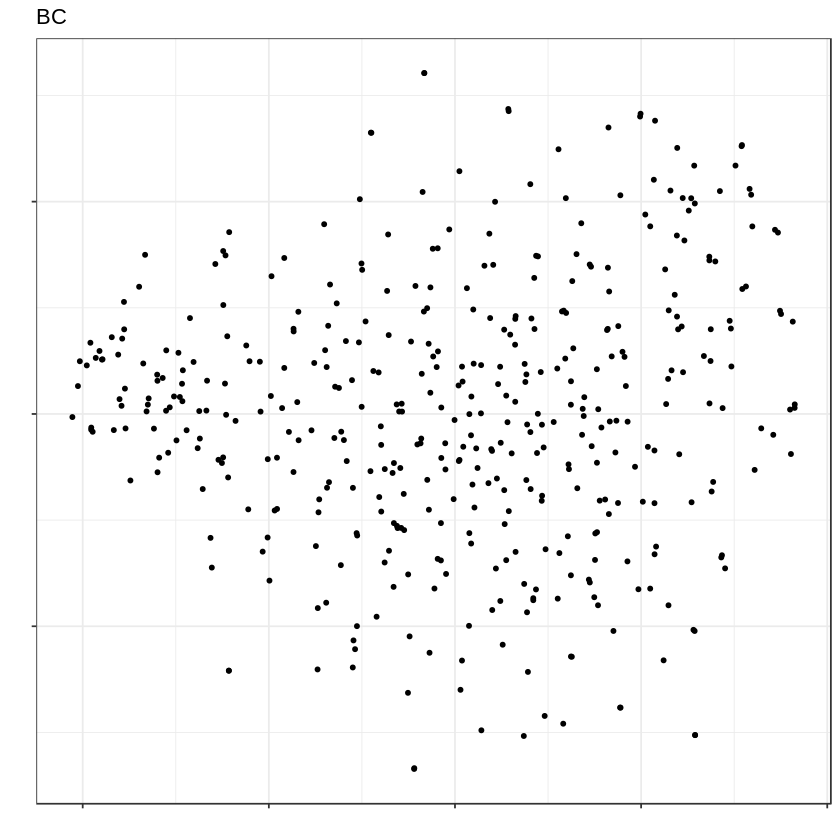

[1] 834   3
[1]  141 1989


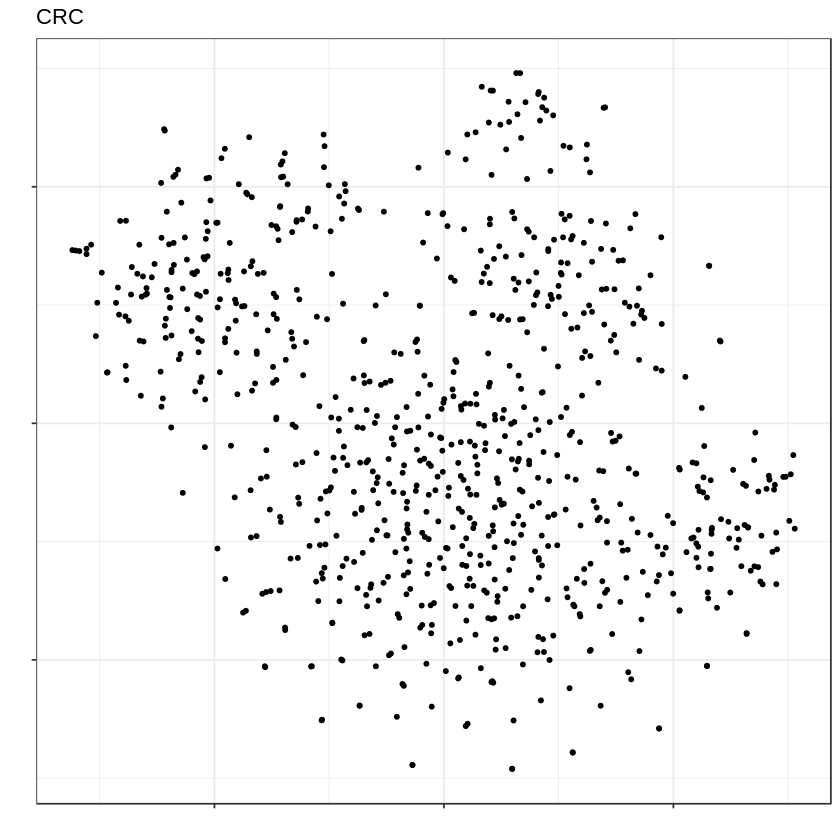

[1] 141   3
[1]  331 1927


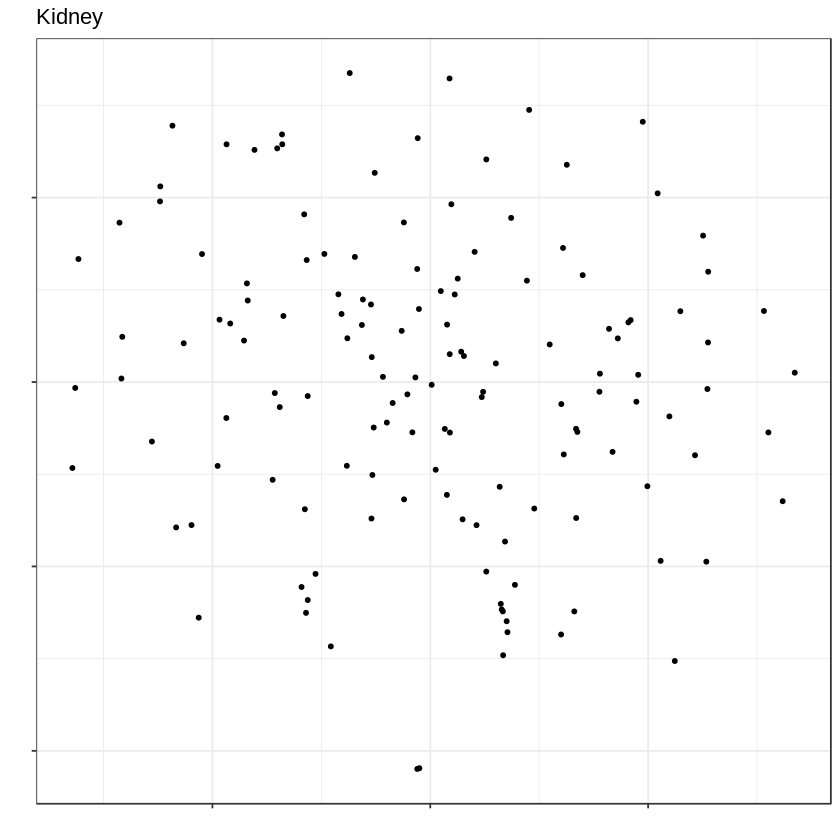

[1] 331   3
[1]  435 1867


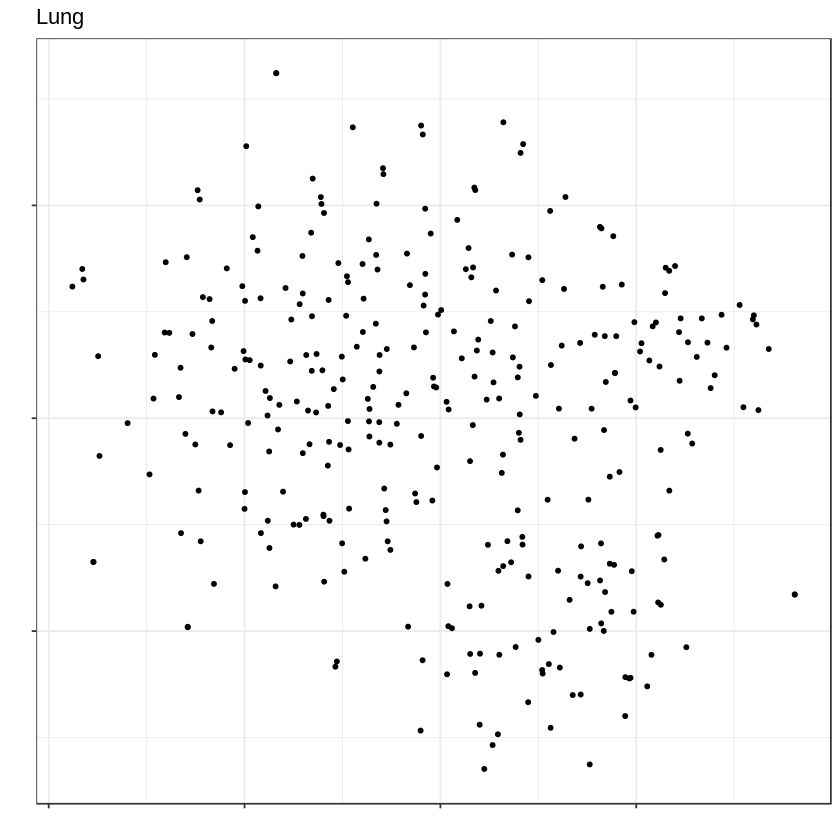

[1] 435   3
[1]  863 1720


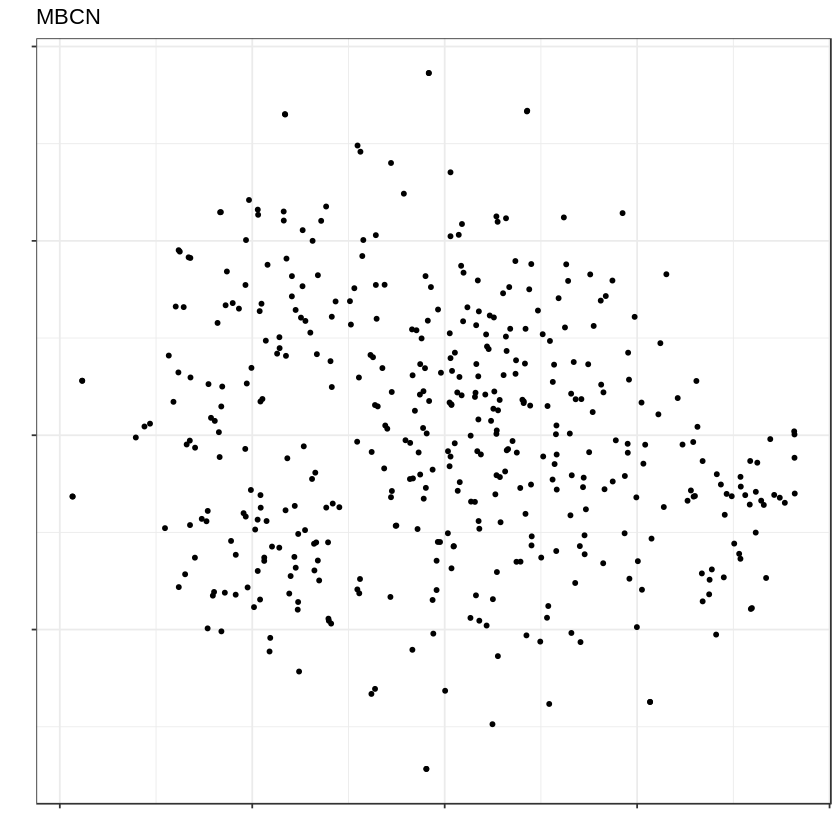

[1] 863   3
[1]  426 1880


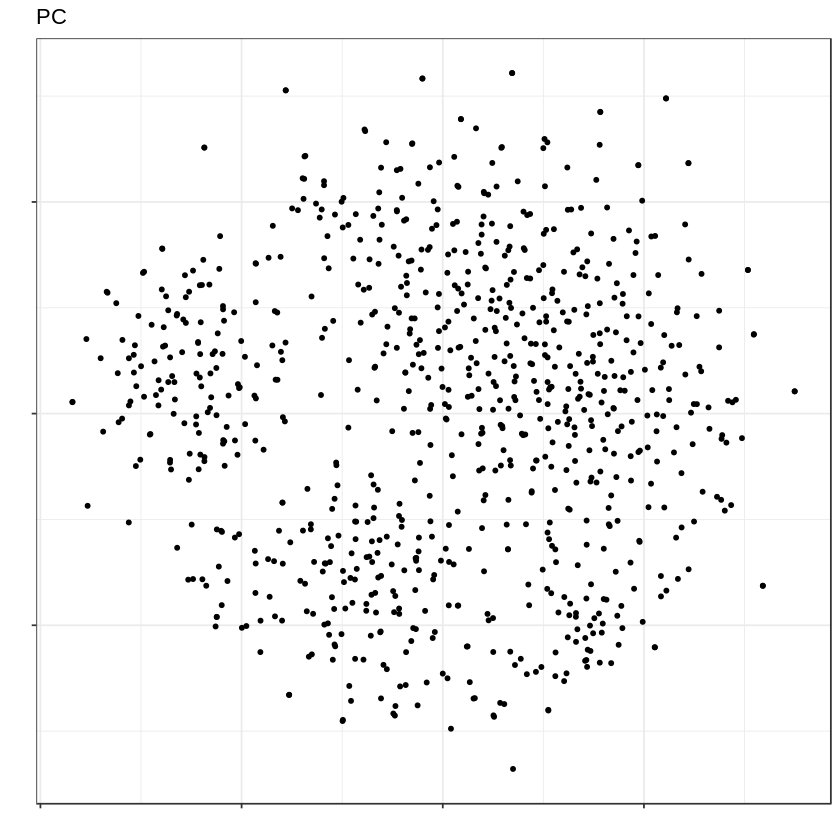

[1] 426   3


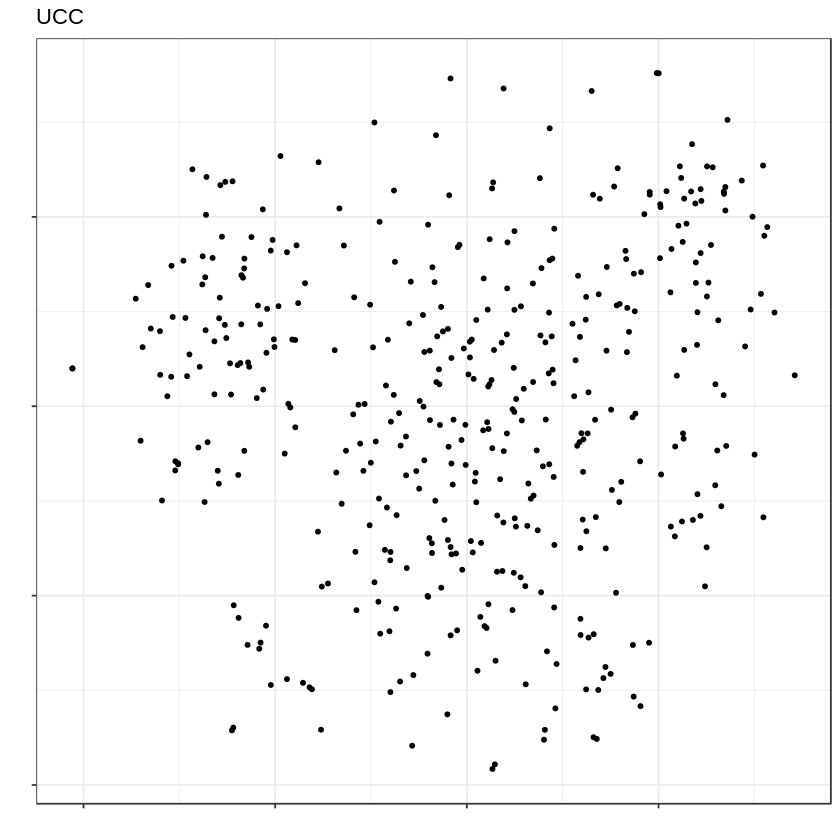

In [8]:
for (type in unique(cancer_cases_methy_ESS_SIV$CancerCellType)){
#type="BC"
BC_cases <- cancer_cases_methy_ESS_SIV[cancer_cases_methy_ESS_SIV$CancerCellType==type,]
BC_cases_cg <- BC_cases[ , !(names(BC_cases) %in% c("CancerCellType"))]
nums <- unlist(lapply(BC_cases_cg, is.numeric))
BC_cases_cg <- BC_cases_cg[,nums]
BC_cases_cg <- BC_cases_cg[ , colSums(is.na(BC_cases_cg)) == 0]
set.seed(9)
    print(dim(BC_cases_cg))
tsne_model_BC = Rtsne(as.matrix(BC_cases_cg), check_duplicates=FALSE, pca=TRUE, perplexity=30, theta=0.5, dims=2)
d_tsne_BC = as.data.frame(tsne_model_BC$Y)
d_tsne_BC$CancerCellType <- BC_cases$CancerCellType
## plotting the results without clustering
p <- ggplot(d_tsne_BC, aes(x=V1, y=V2)) +
  geom_point(size=1) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("") + ylab("") +theme_bw()+
  ggtitle(type) +
  theme(axis.text.x=element_blank(),
        axis.text.y=element_blank())
    print(p)
    print(dim(d_tsne_BC))
}

# Prostate Cancer Case Clustering and Case/Control Classification

In [29]:
cancer_cases_controls <- mccs_ess[mccs_ess$CancerCellType=='PC',] 
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='PC' & mccs_ess$CaseControl==1,] 
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]#do the clustering based on controls
dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]


[1]  863 2210

DBSCAN clustering for 863 objects.
Parameters: eps = 1.5, minPts = 15
The clustering contains 3 cluster(s) and 106 noise points.

  0   1   2   3 
106 474 116 167 

Available fields: cluster, eps, minPts

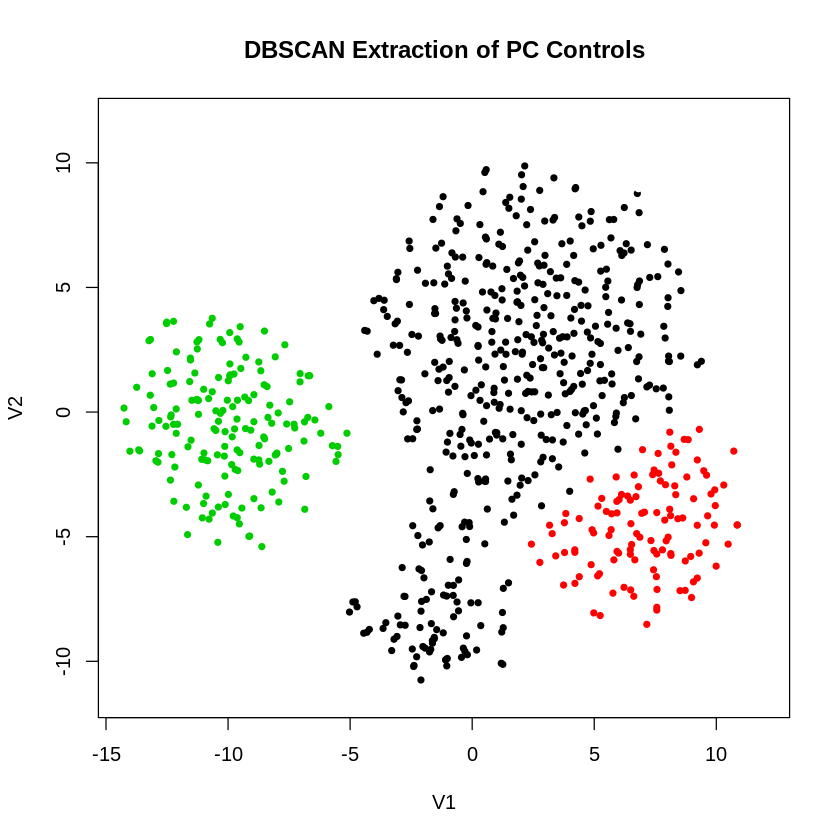

In [20]:
set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)
res <- dbscan::dbscan(d_tsne_3,eps = 1.5, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20,main="DBSCAN Extraction of PC Controls")
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

In [22]:
d_tsne_3$cluster <- res$cluster
d_tsne_3$ID <- cancer_cases$ID
head(d_tsne_3)
tsne_model_cluster1 <- d_tsne_3[d_tsne_3$cluster==1,]
tsne_model_cluster2 <- d_tsne_3[d_tsne_3$cluster==2,]
tsne_model_cluster3 <- d_tsne_3[d_tsne_3$cluster==3,]

V1,V2,cluster,ID
-1.3959189,-4.6476141,1,PC_Pair_1
-14.2628937,0.1604518,3,PC_Pair_2
3.5794374,2.9629831,1,PC_Pair_3
5.9716910,-1.4912276,1,PC_Pair_4
6.3676282,3.5761073,1,PC_Pair_5
0.5680226,5.9295431,1,PC_Pair_6


In [33]:
tsne_model_cluster1_data <- merge(tsne_model_cluster1,cancer_cases_controls,on="ID")
tsne_model_cluster2_data <- merge(tsne_model_cluster2,cancer_cases_controls,on="ID")
tsne_model_cluster3_data <- merge(tsne_model_cluster3,cancer_cases_controls,on="ID")

In [36]:
dim(tsne_model_cluster1_data)
dim(tsne_model_cluster2_data)
dim(tsne_model_cluster3_data)

[1]  948 3839

[1]  232 3839

[1]  334 3839

In [84]:
cancer_cases_methy<- tsne_model_cluster3_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
cancer_cases_methy$CaseControl <- as.factor(tsne_model_cluster3_data$CaseControl)

tsne_model = Rtsne(as.matrix(subset(cancer_cases_methy,select = -c(CaseControl))), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne = as.data.frame(tsne_model$Y)
df <- cbind(d_tsne,cancer_cases_methy)
df$CaseControl<-as.factor(df$CaseControl)
df <- df[c("V1","V2","CaseControl")]
G3 <- ggplot(df, aes(x=V1, y=V2,colour=CaseControl)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("Cluster 3") +
  scale_colour_brewer(palette = "Set2")

cancer_cases_methy<- tsne_model_cluster2_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
cancer_cases_methy$CaseControl <- as.factor(tsne_model_cluster2_data$CaseControl)
tsne_model = Rtsne(as.matrix(subset(cancer_cases_methy,select = -c(CaseControl))), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne = as.data.frame(tsne_model$Y)
df <- cbind(d_tsne,cancer_cases_methy)
df$CaseControl<-as.factor(df$CaseControl)
df <- df[c("V1","V2","CaseControl")]
G2 <- ggplot(df, aes(x=V1, y=V2,colour=CaseControl)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("Cluster 2") +
  scale_colour_brewer(palette = "Set2")

cancer_cases_methy<- tsne_model_cluster1_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
cancer_cases_methy$CaseControl <- as.factor(tsne_model_cluster1_data$CaseControl)
tsne_model = Rtsne(as.matrix(subset(cancer_cases_methy,select = -c(CaseControl))), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne = as.data.frame(tsne_model$Y)
df <- cbind(d_tsne,cancer_cases_methy)
df$CaseControl<-as.factor(df$CaseControl)
df <- df[c("V1","V2","CaseControl")]
G1 <- ggplot(df, aes(x=V1, y=V2,colour=CaseControl)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("Cluster 1") +
  scale_colour_brewer(palette = "Set2")

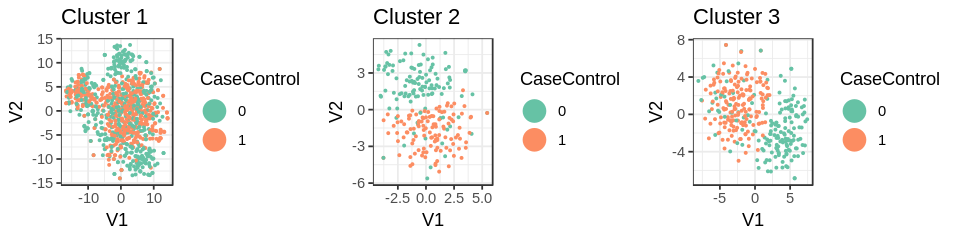

In [85]:
options(repr.plot.width=8, repr.plot.height=2)
grid.arrange(G1,G2,G3,ncol=3,nrow=1)

In [110]:
cancer_cases_methy_c3<- tsne_model_cluster3_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c3, is.numeric))
cancer_cases_methy_c3 <- cancer_cases_methy_c3[,nums]
cancer_cases_methy_c3 <- cancer_cases_methy_c3[ , colSums(is.na(cancer_cases_methy_c3)) == 0]
cancer_cases_methy_c3$CaseControl <- as.factor(tsne_model_cluster3_data$CaseControl)

cancer_cases_methy_c2<- tsne_model_cluster2_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c2, is.numeric))
cancer_cases_methy_c2 <- cancer_cases_methy_c2[,nums]
cancer_cases_methy_c2 <- cancer_cases_methy_c2[ , colSums(is.na(cancer_cases_methy_c2)) == 0]
cancer_cases_methy_c2$CaseControl <- as.factor(tsne_model_cluster2_data$CaseControl)

cancer_cases_methy_c1<- tsne_model_cluster1_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c1, is.numeric))
cancer_cases_methy_c1 <- cancer_cases_methy_c1[,nums]
cancer_cases_methy_c1 <- cancer_cases_methy_c1[ , colSums(is.na(cancer_cases_methy_c1)) == 0]
cancer_cases_methy_c1$CaseControl <- as.factor(tsne_model_cluster1_data$CaseControl)

# Classification

In [134]:
library(caret)
require(randomForest)
library(ROCR)
require(caTools)

RF_auc <- function(df){
    print(dim(df))
    aucs <-c()
    for(iter in 1:2){
        sample = sample.split(df$CaseControl, SplitRatio = .75)
        train = subset(df, sample == TRUE)
        test  = subset(df, sample == FALSE)
        rf_model=randomForest(as.factor(CaseControl) ~.,data = train,ntree=200,mtry=2,importance=TRUE)
        prediction <- predict(rf_model,subset(test,select = -c(CaseControl)))
        table(observed = test$CaseControl,predicted=prediction)
        # Calculate the probability of new observations belonging to each class
        # prediction_for_roc_curve will be a matrix with dimensions data_set_size x number_of_classes
        prediction_for_roc_curve <- predict(rf_model,subset(test,select = -c(CaseControl)),type="prob")
        # Use pretty colours:
        pretty_colours <- c("#F8766D")
        # Specify the different classes 
        classes <- levels(as.factor(test$CaseControl))
        # For each class
        i = 1
         # Define which observations belong to class[i]
        true_values <- ifelse(test$CaseControl==classes[i],2,1)
        pred <- prediction(prediction_for_roc_curve[,i],true_values)

        perf <- performance(pred, "tpr", "fpr")
        options(repr.plot.width=4, repr.plot.height=4)
        #plot(perf,main="ROC Curve",col="#F8766D") 
        auc.perf <- performance(pred, measure = "auc")
        #print(auc.perf@y.values)
        aucs <-c(aucs,auc.perf@y.values)
       
        }
     return(aucs)
}


In [135]:
summary(as.numeric(RF_auc(cancer_cases_methy_c1)))
summary(as.numeric(RF_auc(cancer_cases_methy_c2)))
summary(as.numeric(RF_auc(cancer_cases_methy_c3)))

[1]  948 1845


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5454  0.5640  0.5825  0.5825  0.6011  0.6196 

[1]  232 1883


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6736  0.7032  0.7328  0.7328  0.7623  0.7919 

[1]  334 1935


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7509  0.7657  0.7806  0.7806  0.7955  0.8104 

# Support Vector Machines Classification Cluster 1

In [143]:
trctrl <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
set.seed(3233)
df <- cancer_cases_methy_c1
sample = sample.split(df$CaseControl, SplitRatio = .75)
        train = subset(df, sample == TRUE)
        test  = subset(df, sample == FALSE)

svm_Linear <- train(CaseControl ~., data = train, method = "svmLinear",
                 trControl=trctrl,
                 
                 tuneLength = 10)


Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”Warning message in .local(x, ...):
“Vari

In [144]:
svm_Linear
test_pred <- predict(svm_Linear, newdata = test)
test_pred
confusionMatrix(test_pred, test$CaseControl )

Support Vector Machines with Linear Kernel 

 712 samples
1844 predictors
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 641, 641, 641, 640, 642, 641, ... 
Resampling results:

  Accuracy   Kappa    
  0.5678311  0.1356959

Tuning parameter 'C' was held constant at a value of 1

[1] 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1
 [38] 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1
 [75] 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1
[112] 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0
[149] 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 1 0
[186] 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0
[223] 1 0 1 1 0 1 1 1 1 1 0 0 0 1
Levels: 0 1

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 72 58
         1 46 60
                                          
               Accuracy : 0.5593          
                 95% CI : (0.4935, 0.6237)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 0.0393          
                                          
                  Kappa : 0.1186          
 Mcnemar's Test P-Value : 0.2807          
                                          
            Sensitivity : 0.6102          
            Specificity : 0.5085          
         Pos Pred Value : 0.5538          
         Neg Pred Value : 0.5660          
             Prevalence : 0.5000          
         Detection Rate : 0.3051          
   Detection Prevalence : 0.5508          
      Balanced Accuracy : 0.5593          
                                          
       'Positive' Class : 0               
                                          

# PLS-DA classification Cluster 3

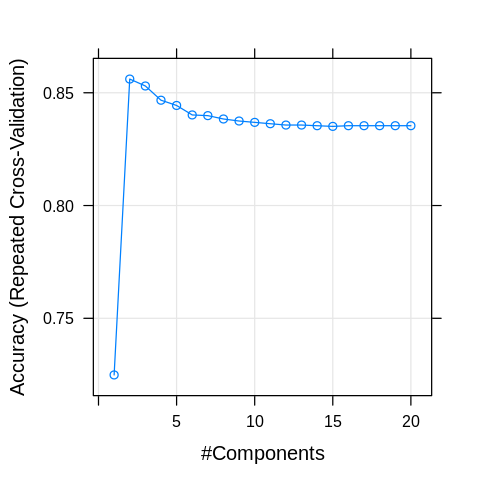

[[1]]
[1] 0.8905896



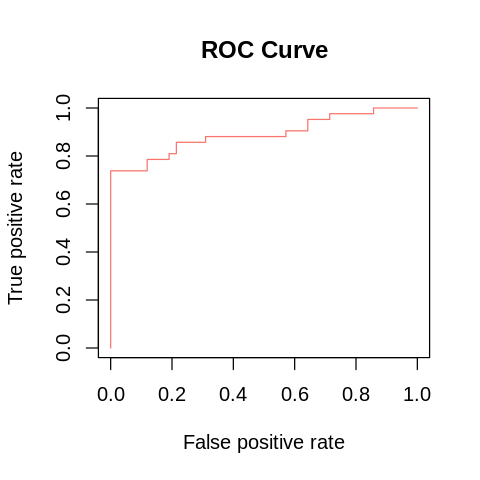

In [159]:
# Compile cross-validation settings

set.seed(100)
myfolds <- createMultiFolds(cancer_cases_methy_c3$CaseControl, k = 5, times = 10)
control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")
 
# Train PLS model
mod1 <- train(CaseControl ~ ., data = cancer_cases_methy_c3,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 trControl = control,
 preProc = c("zv","center","scale"))
 
# Check CV profile
plot(mod1)


mod1 <- train(CaseControl ~ ., data = cancer_cases_methy_c3,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 trControl = control,
 preProc = c("zv","center","scale"))


df <- cancer_cases_methy_c3
sample = sample.split(df$CaseControl, SplitRatio = .75)
train = subset(df, sample == TRUE)
test  = subset(df, sample == FALSE)


mod1 <- train(CaseControl ~ ., data = train,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 preProc = c("zv","center","scale"))


prediction_for_roc_curve <- predict(mod1,subset(test,select = -c(CaseControl)),type="prob")
# Use pretty colours:
pretty_colours <- c("#F8766D")
# Specify the different classes 
classes <- levels(as.factor(test$CaseControl))
# For each class
i = 1
 # Define which observations belong to class[i]
true_values <- ifelse(test$CaseControl==classes[i],2,1)
pred <- prediction(prediction_for_roc_curve[,i],true_values)

perf <- performance(pred, "tpr", "fpr")
options(repr.plot.width=4, repr.plot.height=4)
plot(perf,main="ROC Curve",col="#F8766D") 
auc.perf <- performance(pred, measure = "auc")
print(auc.perf@y.values)

# PLS-DA classification Cluster 2

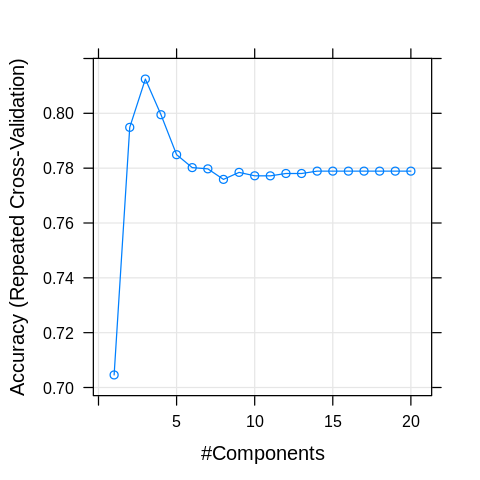

[[1]]
[1] 0.7312723



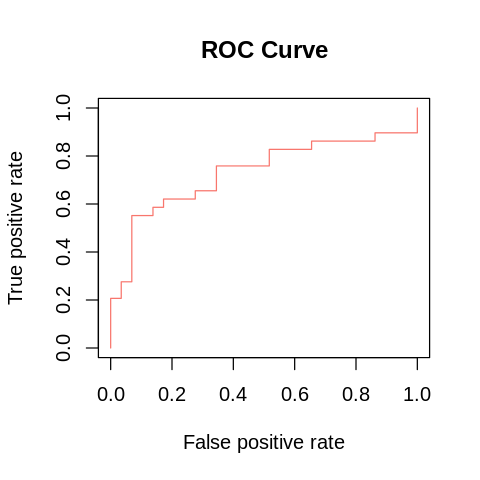

In [158]:

set.seed(100)
myfolds <- createMultiFolds(cancer_cases_methy_c2$CaseControl, k = 5, times = 10)
control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")
 
# Train PLS model
mod1 <- train(CaseControl ~ ., data = cancer_cases_methy_c2,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 trControl = control,
 preProc = c("zv","center","scale"))
 
# Check CV profile
plot(mod1)


mod1 <- train(CaseControl ~ ., data = cancer_cases_methy_c2,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 trControl = control,
 preProc = c("zv","center","scale"))


df <- cancer_cases_methy_c2
sample = sample.split(df$CaseControl, SplitRatio = .75)
train = subset(df, sample == TRUE)
test  = subset(df, sample == FALSE)


mod1 <- train(CaseControl ~ ., data = train,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 preProc = c("zv","center","scale"))


prediction_for_roc_curve <- predict(mod1,subset(test,select = -c(CaseControl)),type="prob")
# Use pretty colours:
pretty_colours <- c("#F8766D")
# Specify the different classes 
classes <- levels(as.factor(test$CaseControl))
# For each class
i = 1
 # Define which observations belong to class[i]
true_values <- ifelse(test$CaseControl==classes[i],2,1)
pred <- prediction(prediction_for_roc_curve[,i],true_values)

perf <- performance(pred, "tpr", "fpr")
options(repr.plot.width=4, repr.plot.height=4)
plot(perf,main="ROC Curve",col="#F8766D") 
auc.perf <- performance(pred, measure = "auc")
print(auc.perf@y.values)

# PLS-DA classification Cluster 1

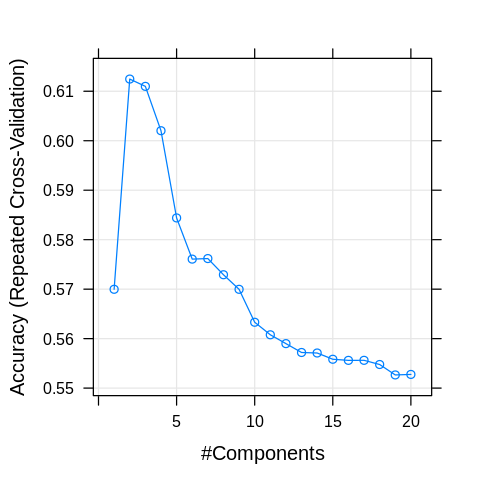

[[1]]
[1] 0.646366



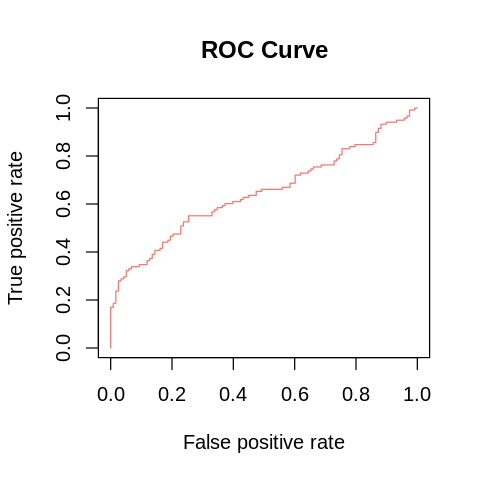

In [160]:
set.seed(100)
myfolds <- createMultiFolds(cancer_cases_methy_c1$CaseControl, k = 5, times = 10)
control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")
 
# Train PLS model
mod1 <- train(CaseControl ~ ., data = cancer_cases_methy_c1,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 trControl = control,
 preProc = c("zv","center","scale"))
 
# Check CV profile
plot(mod1)


mod1 <- train(CaseControl ~ ., data = cancer_cases_methy_c1,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 trControl = control,
 preProc = c("zv","center","scale"))


df <- cancer_cases_methy_c1
sample = sample.split(df$CaseControl, SplitRatio = .75)
train = subset(df, sample == TRUE)
test  = subset(df, sample == FALSE)


mod1 <- train(CaseControl ~ ., data = train,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 preProc = c("zv","center","scale"))


prediction_for_roc_curve <- predict(mod1,subset(test,select = -c(CaseControl)),type="prob")
# Use pretty colours:
pretty_colours <- c("#F8766D")
# Specify the different classes 
classes <- levels(as.factor(test$CaseControl))
# For each class
i = 1
 # Define which observations belong to class[i]
true_values <- ifelse(test$CaseControl==classes[i],2,1)
pred <- prediction(prediction_for_roc_curve[,i],true_values)

perf <- performance(pred, "tpr", "fpr")
options(repr.plot.width=4, repr.plot.height=4)
plot(perf,main="ROC Curve",col="#F8766D") 
auc.perf <- performance(pred, measure = "auc")
print(auc.perf@y.values)

In [161]:
varImp(mod1)


Attaching package: ‘pls’

The following object is masked from ‘package:caret’:

    R2

The following object is masked from ‘package:stats’:

    loadings



pls variable importance

  only 20 most important variables shown (out of 1843)

           Overall
cg21548813  100.00
cg07332563   96.77
cg15383120   95.83
cg18110333   95.22
cg03395511   93.85
cg01516881   93.31
cg05064044   88.18
cg16615357   77.22
cg18797653   76.02
cg06536614   74.51
cg00124993   73.50
cg25340688   73.39
cg26896946   73.16
cg26328633   71.61
cg07158503   69.34
cg11608150   69.08
cg06478886   63.84
cg18678645   63.78
cg22582999   42.96
cg19876987   39.42